In [1]:
# Block 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

print("Setup complete.")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Setup complete.


In [2]:
# Block 2: Load and concatenate CSV data
import os
from glob import glob

# Replace with the folder where your CSVs are stored
data_folder = "."

# Grab all CSVs in that folder
csv_files = sorted(glob(os.path.join(data_folder, "*.csv")))

# Read and concatenate all CSVs
all_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Convert timestamp to datetime
all_data["timestamp"] = pd.to_datetime(all_data["timestamp"])

# Sort just in case
all_data = all_data.sort_values("timestamp").reset_index(drop=True)

print("Data loaded:", all_data["timestamp"].min(), "to", all_data["timestamp"].max())

Data loaded: 2020-05-11 08:00:00 to 2025-05-01 23:55:00


In [18]:
# Block 3: Build daily rows with 9:30 and 9:35 close prices
daily_rows = []

# Group by date
for date, group in all_data.groupby(all_data["timestamp"].dt.date):
    group = group.sort_values("timestamp")

    open_row = group[group["timestamp"].dt.time == pd.to_datetime("09:30").time()]
    after_5min_row = group[group["timestamp"].dt.time == pd.to_datetime("09:35").time()]

    if not open_row.empty and not after_5min_row.empty:
        row = {
            "date": pd.to_datetime(date),
            "close_930": open_row.iloc[0]["close"],
            "close_935": after_5min_row.iloc[0]["close"],
            "volume": after_5min_row.iloc[0]["volume"]
        }
        daily_rows.append(row)

model_df = pd.DataFrame(daily_rows)
print("Built daily model_df:", model_df.shape)

Built daily model_df: (1111, 4)


In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Start from model_df created in Block 3
model_df["date"] = pd.to_datetime(model_df["date"])

# Calendar features
model_df["day_of_week"] = model_df["date"].dt.weekday
model_df["is_monday"] = (model_df["day_of_week"] == 0).astype(int)
model_df["is_friday"] = (model_df["day_of_week"] == 4).astype(int)
model_df["month"] = model_df["date"].dt.month
model_df["year"] = model_df["date"].dt.year
model_df["quarter"] = model_df["date"].dt.quarter
model_df["is_month_start"] = model_df["date"].dt.is_month_start.astype(int)
model_df["is_month_end"] = model_df["date"].dt.is_month_end.astype(int)
model_df["is_quarter_start"] = model_df["date"].dt.is_quarter_start.astype(int)
model_df["is_quarter_end"] = model_df["date"].dt.is_quarter_end.astype(int)

# Season feature
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Fall"

model_df["season"] = model_df["month"].apply(get_season)
model_df = pd.get_dummies(model_df, columns=["season"], prefix="season")

# Holiday features
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=model_df["date"].min(), end=model_df["date"].max())
model_df["is_holiday"] = model_df["date"].isin(holidays).astype(int)
model_df["prev_day"] = model_df["date"] - pd.Timedelta(days=1)
model_df["is_after_holiday"] = model_df["prev_day"].isin(holidays).astype(int)

# First trading day of the month
first_of_month = model_df.groupby(model_df["date"].dt.to_period("M"))["date"].min().values
model_df["is_first_trading_day"] = model_df["date"].isin(first_of_month).astype(int)

# Target: Did price go up between 9:30 and 9:35?
model_df["went_up"] = (model_df["close_935"] > model_df["close_930"]).astype(int)

# Print result
print("Calendar features added. Columns now:", model_df.columns.tolist())

Calendar features added. Columns now: ['date', 'close_930', 'close_935', 'volume', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday', 'prev_day', 'is_after_holiday', 'is_first_trading_day', 'went_up']


In [20]:
# Block 5: Add Previous Day Features

# Step 1: Create previous day reference
model_df["prev_day"] = model_df["date"].shift(1)

# Step 2: Create a DataFrame with previous day's open and close
df_prev = model_df[["date", "close_930"]].copy()
df_prev.columns = ["prev_day", "prev_day_open"]

df_prev["prev_day_close"] = model_df["close_935"].shift(1).values

# Step 3: Merge previous day data
model_df = pd.merge(model_df, df_prev, on="prev_day", how="left")

# Step 4: Create previous day return
model_df["prev_day_return"] = (
    (model_df["prev_day_close"] - model_df["prev_day_open"]) / model_df["prev_day_open"]
)

# Step 5: Drop early NaNs
model_df = model_df.dropna(subset=["prev_day_return"]).reset_index(drop=True)

# Confirm columns
print("Columns after adding prev day features:", model_df.columns.tolist())

Columns after adding prev day features: ['date', 'close_930', 'close_935', 'volume', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday', 'prev_day', 'is_after_holiday', 'is_first_trading_day', 'went_up', 'prev_day_open', 'prev_day_close', 'prev_day_return']


In [21]:
# Block 6: Add Technical Indicators

def add_technical_indicators(df):
    # RSI
    delta = df["close_935"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["rsi_14"] = 100 - (100 / (1 + rs))

    # SMA and ratios
    df["sma_5"] = df["close_935"].rolling(window=5).mean()
    df["sma_20"] = df["close_935"].rolling(window=20).mean()
    df["sma_ratio"] = df["sma_5"] / df["sma_20"]
    df["sma_distance"] = (df["close_935"] - df["sma_20"]) / df["sma_20"]

    # Volatility
    df["prior_volatility"] = df["close_930"].rolling(window=5).std()

    # Bollinger Bands
    df["bb_middle"] = df["sma_20"]
    df["bb_std"] = df["close_935"].rolling(window=20).std()
    df["bb_upper"] = df["bb_middle"] + 2 * df["bb_std"]
    df["bb_lower"] = df["bb_middle"] - 2 * df["bb_std"]
    df["bollinger_width"] = (df["bb_upper"] - df["bb_lower"]) / df["bb_middle"]
    df["bollinger_position"] = (df["close_935"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])

    # MACD
    ema12 = df["close_935"].ewm(span=12, adjust=False).mean()
    ema26 = df["close_935"].ewm(span=26, adjust=False).mean()
    df["macd"] = ema12 - ema26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
    df["macd_diff"] = df["macd"] - df["macd_signal"]

    # Overnight gap
    df["overnight_gap"] = (df["close_930"] - df["prev_day_close"]) / df["prev_day_close"]

    # Previous day movement
    df["prev_day_change"] = (df["prev_day_close"] - df["prev_day_open"]) / df["prev_day_open"]
    df["prev_day_range_pct"] = (df["prev_day_close"] - df["prev_day_open"]).abs() / df["prev_day_open"]

    return df

model_df = add_technical_indicators(model_df)
model_df = model_df.dropna().reset_index(drop=True)

print("Technical indicators added. Columns now:", model_df.columns.tolist())

Technical indicators added. Columns now: ['date', 'close_930', 'close_935', 'volume', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday', 'prev_day', 'is_after_holiday', 'is_first_trading_day', 'went_up', 'prev_day_open', 'prev_day_close', 'prev_day_return', 'rsi_14', 'sma_5', 'sma_20', 'sma_ratio', 'sma_distance', 'prior_volatility', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bollinger_width', 'bollinger_position', 'macd', 'macd_signal', 'macd_diff', 'overnight_gap', 'prev_day_change', 'prev_day_range_pct']


In [22]:
# Construct df_engineered with everything from the current model_df
df_engineered = model_df.copy()

# Confirm that all expected features are present
print("Engineered columns:", df_engineered.columns.tolist())

Engineered columns: ['date', 'close_930', 'close_935', 'volume', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday', 'prev_day', 'is_after_holiday', 'is_first_trading_day', 'went_up', 'prev_day_open', 'prev_day_close', 'prev_day_return', 'rsi_14', 'sma_5', 'sma_20', 'sma_ratio', 'sma_distance', 'prior_volatility', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bollinger_width', 'bollinger_position', 'macd', 'macd_signal', 'macd_diff', 'overnight_gap', 'prev_day_change', 'prev_day_range_pct']


In [23]:
# Block 7: Filter full_df to 9:30 and 9:35 rows only

full_df = all_data.copy()
full_df["time"] = full_df["timestamp"].dt.strftime("%H:%M")
full_df = full_df[full_df["time"].isin(["09:30", "09:35"])].reset_index(drop=True)
full_df["date"] = full_df["timestamp"].dt.date  # add date column if not already
full_df = full_df.drop(columns=["time"])  # optional: drop time column

print("Filtered to 9:30 and 9:35 AM rows only:", full_df.shape)

Filtered to 9:30 and 9:35 AM rows only: (4856, 9)


In [24]:
model_df["date"] = pd.to_datetime(model_df["date"])
full_df["date"] = pd.to_datetime(full_df["date"])

In [25]:
# Block 8: Add Volume-Based Features

# Step 0: Recreate time column (needed if kernel restarted)
full_df["time"] = full_df["timestamp"].dt.strftime("%H:%M")

# Step 1: Compute volume rolling stats using only 09:35 rows
volume_df = full_df[full_df["time"] == "09:35"].copy()
volume_df = volume_df.sort_values("timestamp")  # make sure it's sorted
volume_df["volume_5day_avg"] = volume_df["volume"].rolling(window=5).mean()
volume_df["volume_5day_ratio"] = volume_df["volume"] / volume_df["volume_5day_avg"]

# Step 2: Now this is our model_df (the one we’ll use from now on)
model_df = volume_df.reset_index(drop=True)

# Step 3: Drop early NaNs due to rolling window
model_df = model_df.dropna(subset=["volume_5day_avg", "volume_5day_ratio"])

print("Volume features added. Columns now:", model_df.columns.tolist())

Volume features added. Columns now: ['volume', 'vw', 'open', 'close', 'high', 'low', 'timestamp', 'trades', 'date', 'time', 'volume_5day_avg', 'volume_5day_ratio']


In [26]:
print("df_engineered columns:", df_engineered.columns.tolist())

df_engineered columns: ['date', 'close_930', 'close_935', 'volume', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday', 'prev_day', 'is_after_holiday', 'is_first_trading_day', 'went_up', 'prev_day_open', 'prev_day_close', 'prev_day_return', 'rsi_14', 'sma_5', 'sma_20', 'sma_ratio', 'sma_distance', 'prior_volatility', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bollinger_width', 'bollinger_position', 'macd', 'macd_signal', 'macd_diff', 'overnight_gap', 'prev_day_change', 'prev_day_range_pct']


In [27]:
# Block 9: Merge engineered features into 09:35 filtered model_df

# Step 1: Define all engineered columns we want to keep
calendar_and_tech_cols = [
    "date", "close_930", "close_935", "day_of_week", "is_monday", "is_friday",
    "month", "year", "quarter", "is_month_start", "is_month_end",
    "is_quarter_start", "is_quarter_end", "season_Winter", "season_Spring",
    "season_Summer", "season_Fall", "is_holiday", "is_after_holiday",
    "is_first_trading_day", "went_up", "prev_day", "prev_day_open",
    "prev_day_close", "prev_day_return", "rsi_14", "sma_5", "sma_20",
    "sma_ratio", "sma_distance", "prior_volatility", "bb_middle", "bb_std",
    "bb_upper", "bb_lower", "bollinger_width", "bollinger_position",
    "macd", "macd_signal", "macd_diff", "overnight_gap",
    "prev_day_change", "prev_day_range_pct"
]

# Step 2: Merge the engineered feature data into model_df (which is 09:35 rows only)
model_df["date"] = pd.to_datetime(model_df["date"])
df_engineered["date"] = pd.to_datetime(df_engineered["date"])  # ensure matching dtypes

model_df = pd.merge(
    model_df,
    df_engineered[calendar_and_tech_cols],
    on="date",
    how="left"
)

# Step 3: Drop rows with missing values
model_df = model_df.dropna().reset_index(drop=True)

print("Final model_df shape after merge:", model_df.shape)

Final model_df shape after merge: (2256, 54)


In [28]:
#Block 10
# Step 1: Choose refined feature set
refined_features = [
    "is_quarter_start", "is_month_start", "is_quarter_end", "is_month_end",
    "day_of_week", "month", "year", "season_Winter", "season_Spring",
    "season_Summer", "season_Fall", "is_holiday", "is_after_holiday",
    "is_first_trading_day", "overnight_gap", "sma_ratio", "sma_distance",
    "prior_volatility", "rsi_14", "bollinger_width", "bollinger_position",
    "macd_diff", "prev_day_change", "prev_day_range_pct", "volume_5day_ratio"
]

# Step 2: Filter model_df to include only selected features + target
model_df_final = model_df[refined_features + ["went_up"]].dropna()

# Step 3: Create X (features) and y (target)
X = model_df_final[refined_features]
y = model_df_final["went_up"]

# Step 4: Train/test split (by date order, 80/20)
split_index = int(len(model_df_final) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Preview
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 1804, Test size: 452


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Step 1: Train model
model = XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
model.fit(X_train, y_train)

# Step 2: Predict on test set
y_pred = model.predict(X_test)

# Step 3: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 4: Calculate win rate (precision on predicted 'went_up' = 1)
predicted_ups = (y_pred == 1)
actual_ups = (y_test == 1)
if predicted_ups.sum() > 0:
    win_rate = (y_pred[predicted_ups] == y_test[predicted_ups]).mean()
    print(f"Win Rate on Predicted 'Buy' Days: {win_rate:.4f}")
else:
    print("No 'went_up' predictions to evaluate win rate.")

Test Accuracy: 0.5509
Win Rate on Predicted 'Buy' Days: 0.5617


In [30]:
# Block 12: Confidence-Based Predictions with Probabilities

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Step 1: Retrain model with probability support
model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)

# Step 2: Predict probabilities on test set
probs = model.predict_proba(X_test)[:, 1]  # probability went_up = 1

# Step 3: Define threshold for confidence
threshold = 0.70

# Step 4: Filter predictions with high confidence
confident_indices = (probs >= threshold) | (probs <= (1 - threshold))
confident_preds = (probs[confident_indices] >= threshold).astype(int)
confident_truths = y_test.iloc[confident_indices]

# Step 5: Evaluate
confident_accuracy = accuracy_score(confident_truths, confident_preds)
print(f"Confidence threshold: {threshold}")
print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

Confidence threshold: 0.7
Decisions made: 298 / 452
Accuracy on confident predictions: 0.5940


In [31]:
# Block 13: Save confident predictions

# Get dates for the test set
confident_dates = model_df_final.iloc[split_index:].reset_index(drop=True).iloc[confident_indices].copy()
confident_dates["prediction"] = confident_preds
confident_dates["actual"] = confident_truths.values
confident_dates["probability"] = probs[confident_indices]

# Sort by probability to inspect strongest signals
confident_dates = confident_dates.sort_values(by="probability", ascending=False)

# Save to CSV
confident_dates.to_csv("confident_predictions.csv", index=False)
print("Saved confident predictions for review.")

Saved confident predictions for review.


In [33]:
#Block 14
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model_df_final["date"] = model_df["date"]
# Step 1: Define the time-based cutoff
cutoff_date = pd.to_datetime("2024-01-01")

# Step 2: Time-based train/test split
train_df = model_df_final[model_df_final["date"] < cutoff_date]
test_df  = model_df_final[model_df_final["date"] >= cutoff_date]

X_train = train_df[refined_features]
y_train = train_df["went_up"]
X_test  = test_df[refined_features]
y_test  = test_df["went_up"]

# Step 3: Train the model
model = XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
model.fit(X_train, y_train)

# Step 4: Predict probabilities
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.70

# Step 5: Confidence filtering
confident_mask = (probs >= threshold) | (probs <= 1 - threshold)
confident_preds = (probs[confident_mask] >= threshold).astype(int)
confident_truths = y_test.iloc[confident_mask]

# Step 6: Evaluation
confident_accuracy = accuracy_score(confident_truths, confident_preds)
print(f"Out-of-sample confidence test (2024+):")
print(f"Threshold: {threshold}")
print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

Out-of-sample confidence test (2024+):
Threshold: 0.7
Decisions made: 375 / 600
Accuracy on confident predictions: 0.5413


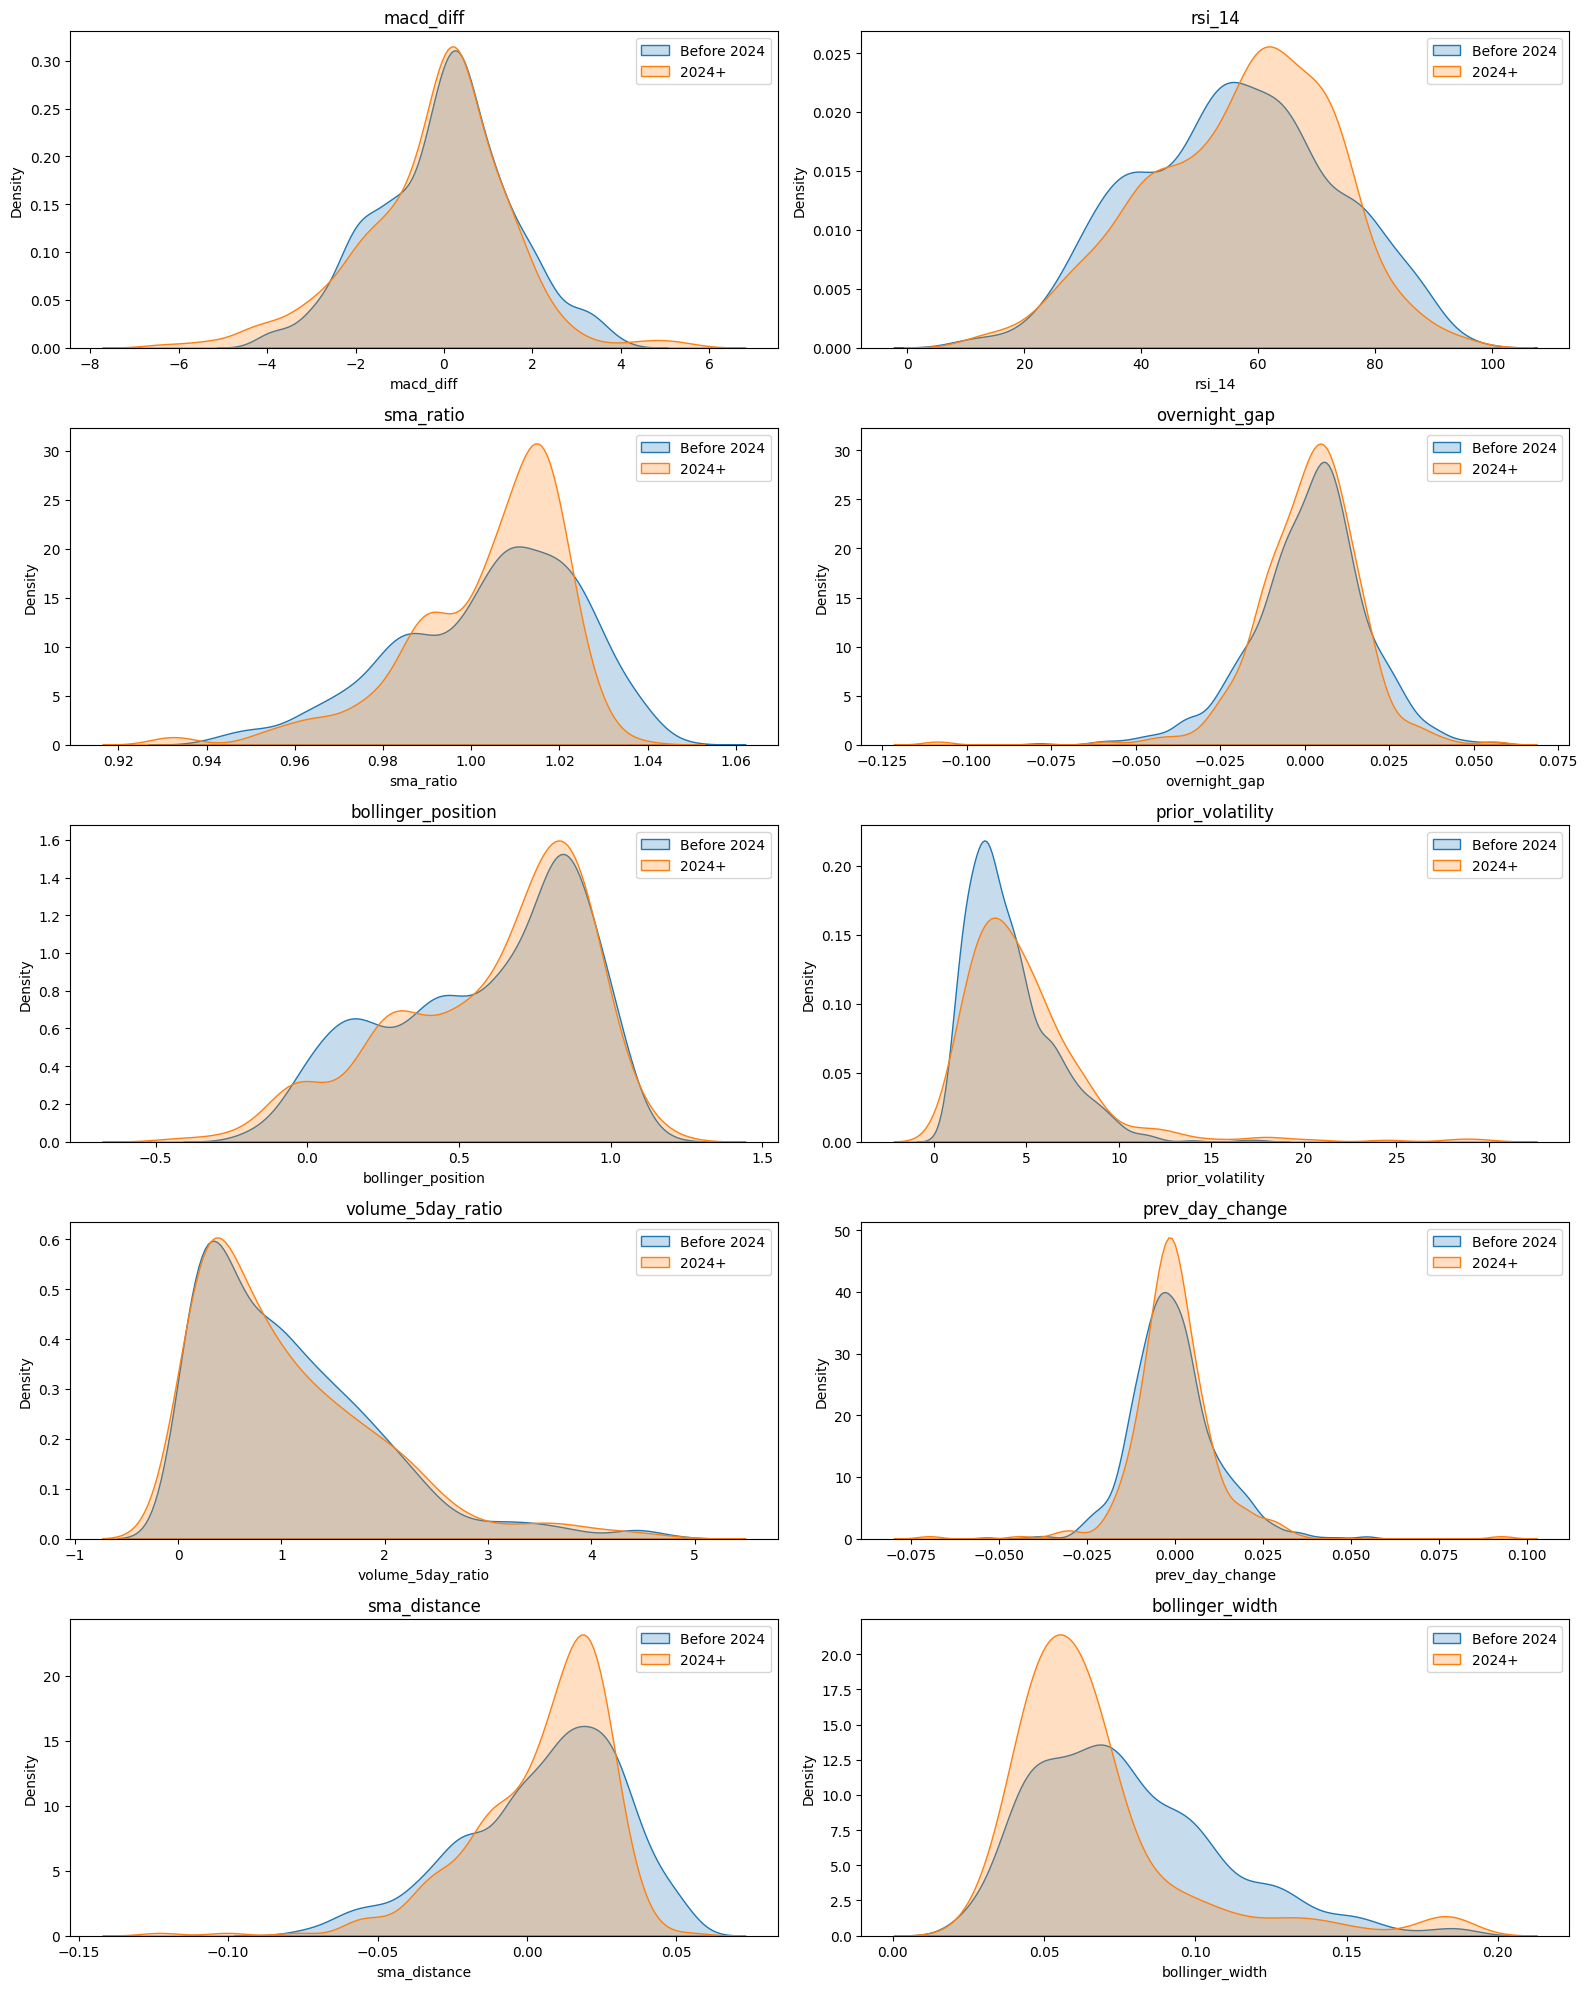

In [34]:
#Block 15

# Block: Visualize Feature Drift Between Pre-2024 and 2024+
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'year' column is an integer
model_df_final["year"] = model_df_final["year"].astype(int)

# Split into pre-2024 and 2024+ datasets
pre_2024 = model_df_final[model_df_final["year"] < 2024]
post_2024 = model_df_final[model_df_final["year"] >= 2024]

# Key features to compare
selected_features = [
    "macd_diff", "rsi_14", "sma_ratio", "overnight_gap",
    "bollinger_position", "prior_volatility", "volume_5day_ratio",
    "prev_day_change", "sma_distance", "bollinger_width"
]

# Plot distribution comparisons
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.kdeplot(pre_2024[feature], label="Before 2024", ax=axes[i], fill=True)
    sns.kdeplot(post_2024[feature], label="2024+", ax=axes[i], fill=True)
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [37]:
# Block 16: Refined Feature Set After Importance Analysis
refined_features = [
    "is_first_trading_day", "macd_diff", "day_of_week", "overnight_gap",
    "bollinger_position", "prior_volatility", "rsi_14", "sma_ratio",
    "prev_day_range_pct", "sma_distance", "month", "bollinger_width",
    "year", "prev_day_change"
]

# Filter final dataset
model_df_final = model_df[refined_features + ["went_up"]].dropna()

# Redefine X and y
X = model_df_final[refined_features]
y = model_df_final["went_up"]

# Re-split by date
split_index = int(len(model_df_final) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Retrain model
model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Re-evaluate
y_pred = model.predict(X_test)
print("Test Accuracy (pruned):", accuracy_score(y_test, y_pred))

# Confidence filtering again
y_probs = model.predict_proba(X_test)[:, 1]
threshold = 0.7
confident_mask = (y_probs > threshold) | (y_probs < 1 - threshold)
confident_preds = y_pred[confident_mask]
confident_actuals = y_test.iloc[confident_mask]

print("Confident decisions made:", len(confident_preds), "/", len(y_test))
print("Accuracy on confident decisions:", accuracy_score(confident_actuals, confident_preds))

[22:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Accuracy (pruned): 0.5752212389380531
Confident decisions made: 100 / 452
Accuracy on confident decisions: 0.58


In [36]:
# Print sorted feature importances
importances = model.get_booster().get_score(importance_type='gain')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importances:
    print(f"{feature}: {score:.4f}")

is_first_trading_day: 5.6484
season_Winter: 2.4374
macd_diff: 2.2873
day_of_week: 2.1351
overnight_gap: 2.0183
bollinger_position: 2.0027
prior_volatility: 1.9988
rsi_14: 1.9409
sma_ratio: 1.8538
prev_day_range_pct: 1.8116
sma_distance: 1.7758
season_Spring: 1.7429
month: 1.7231
bollinger_width: 1.7136
season_Fall: 1.6896
year: 1.5740
prev_day_change: 1.4604
volume_5day_ratio: 1.2775
is_after_holiday: 1.1531
season_Summer: 0.7865


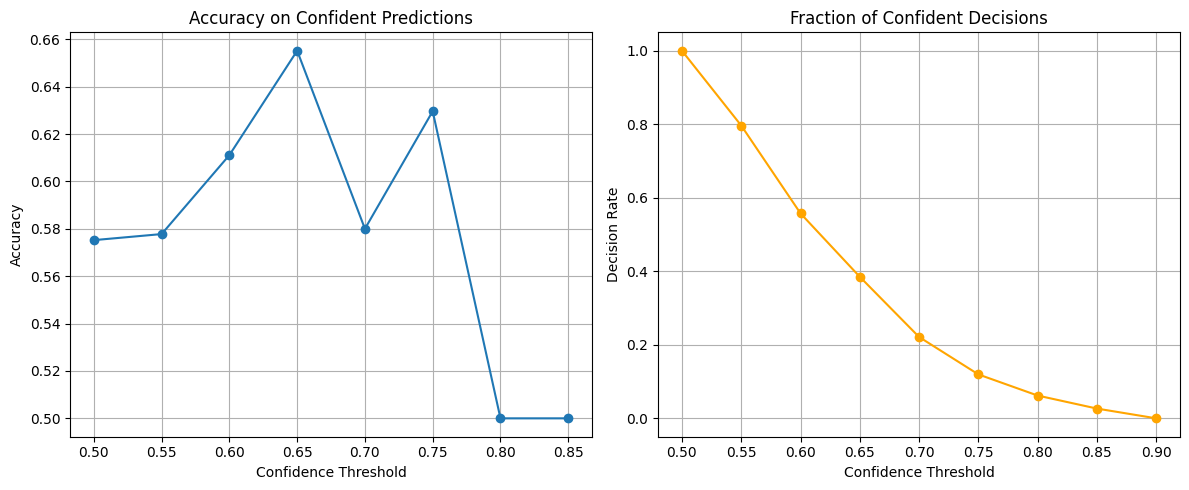

In [38]:
#Block 17

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Generate probabilities for the test set
probs = model.predict_proba(X_test)[:, 1]
y_test_reset = y_test.reset_index(drop=True)

# Store results
thresholds = np.arange(0.5, 0.91, 0.05)
accuracies = []
decision_rates = []

for threshold in thresholds:
    confident_mask = (probs >= threshold) | (probs <= (1 - threshold))
    if confident_mask.sum() == 0:
        accuracies.append(np.nan)
        decision_rates.append(0)
        continue

    confident_preds = (probs[confident_mask] >= threshold).astype(int)
    confident_truths = y_test_reset[confident_mask]

    acc = accuracy_score(confident_truths, confident_preds)
    decision_rate = len(confident_preds) / len(y_test)

    accuracies.append(acc)
    decision_rates.append(decision_rate)

# Plot accuracy vs threshold
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, accuracies, marker='o')
plt.title("Accuracy on Confident Predictions")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot decision rate
plt.subplot(1, 2, 2)
plt.plot(thresholds, decision_rates, marker='o', color='orange')
plt.title("Fraction of Confident Decisions")
plt.xlabel("Confidence Threshold")
plt.ylabel("Decision Rate")
plt.grid(True)

plt.tight_layout()
plt.show()

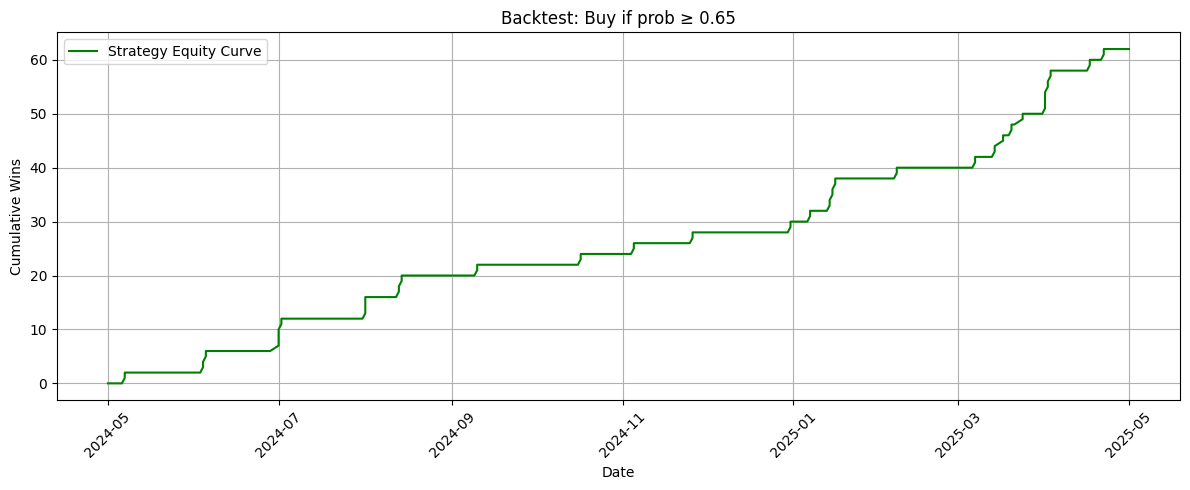

Threshold: 0.65
Total trades: 92
Strategy accuracy on trades: 0.6739


In [40]:
# Block 18: Backtest strategy using 0.65 threshold
from matplotlib.dates import DateFormatter

CONFIDENCE_THRESHOLD = 0.65

# Reset index for plotting
y_test_reset = y_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)
test_dates = model_df.iloc[-len(X_test):]["date"].reset_index(drop=True)
# Predict probabilities
probs = model.predict_proba(X_test_reset)[:, 1]

# Strategy: Buy if confident it's going up
confident_buy = probs >= CONFIDENCE_THRESHOLD
actual_movement = y_test_reset

# Simulate equity curve
returns = (actual_movement * confident_buy).astype(int)
equity = returns.cumsum()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(test_dates, equity, label="Strategy Equity Curve", color="green")
plt.title(f"Backtest: Buy if prob ≥ {CONFIDENCE_THRESHOLD}")
plt.xlabel("Date")
plt.ylabel("Cumulative Wins")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results
total_trades = confident_buy.sum()
accuracy = accuracy_score(actual_movement[confident_buy], np.ones(total_trades))
print(f"Threshold: {CONFIDENCE_THRESHOLD}")
print(f"Total trades: {total_trades}")
print(f"Strategy accuracy on trades: {accuracy:.4f}")

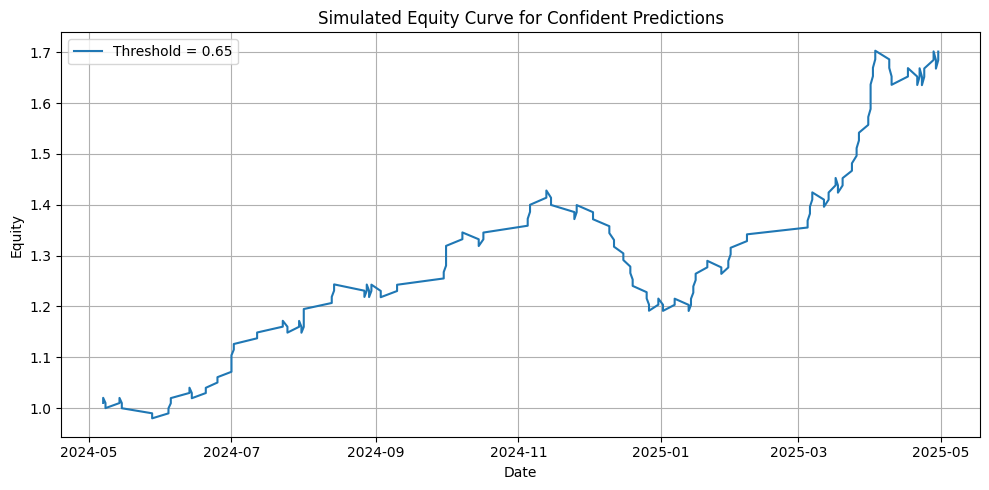

In [41]:
#Block 19
import matplotlib.pyplot as plt
import numpy as np

# Set confidence threshold
threshold = 0.65

# Reset y_test and prediction arrays
y_test_reset = y_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)
test_dates = model_df.iloc[split_index:]["date"].reset_index(drop=True)

# Get predicted probabilities
probs = model.predict_proba(X_test_reset)[:, 1]
preds = (probs > 0.5).astype(int)

# Filter for confident trades
confident_mask = (probs >= threshold) | (probs <= 1 - threshold)
confident_preds = preds[confident_mask]
confident_actuals = y_test_reset[confident_mask].values
confident_dates = test_dates[confident_mask].values

# Simulate equity curve
equity = [1]
for pred, actual in zip(confident_preds, confident_actuals):
    if pred == actual:
        equity.append(equity[-1] * 1.01)  # +1% gain
    else:
        equity.append(equity[-1] * 0.99)  # -1% loss

# Plot
plt.figure(figsize=(10, 5))
plt.plot(confident_dates, equity[1:], label=f'Threshold = {threshold}')
plt.title("Simulated Equity Curve for Confident Predictions")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate position sizing with variable confidence thresholds
def simulate_equity_with_position_sizing(test_dates, y_test, y_probs, threshold_base=0.65):
    confident_mask = y_probs >= threshold_base
    confident_dates = test_dates[confident_mask].reset_index(drop=True)
    confident_actuals = y_test[confident_mask].reset_index(drop=True)
    confident_probs = y_probs[confident_mask]

    # Assign position size: 1.0 for medium confidence, 2.0 for high
    sizes = np.where(confident_probs >= 0.85, 2.0, 1.0)

    # Simulate equity
    equity = [1.0]
    for i in range(len(confident_actuals)):
        prev = equity[-1]
        ret = sizes[i] if confident_actuals[i] == 1 else -0.5 * sizes[i]
        equity.append(prev * (1 + ret * 0.01))  # Assume 1% up/down movement

    equity_series = pd.Series(equity[1:], index=confident_dates)

    # Plot equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(equity_series.index, equity_series.values, label="Position-Sized Equity", color="purple")
    plt.title("Simulated Equity Curve with Position Sizing")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

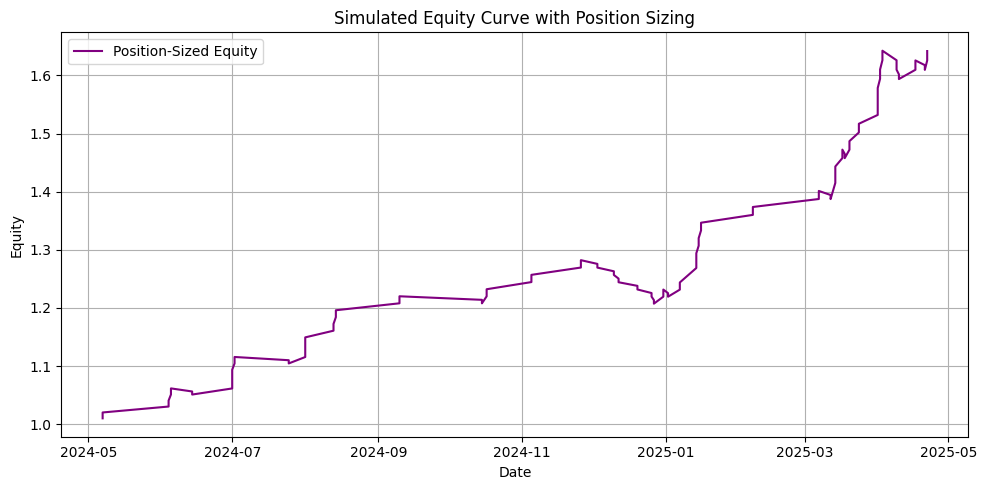

In [44]:
simulate_equity_with_position_sizing(test_dates, y_test_reset, probs, threshold_base=0.65)

In [48]:
# Create position equity series if not already done
position_equity = pd.Series(equity[1:], index=confident_dates)

# Compute trade-by-trade returns
trade_returns = position_equity.pct_change().dropna()

# Strategy metrics function
def compute_strategy_metrics(equity_curve, trade_returns):
    total_return = equity_curve.iloc[-1] - 1.0
    years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    cagr = (equity_curve.iloc[-1]) ** (1 / years) - 1 if years > 0 else 0

    # Drawdown calculation
    rolling_max = equity_curve.cummax()
    drawdowns = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    return {
        "CAGR": cagr,
        "Total Return": total_return,
        "Max Drawdown": max_drawdown,
        "Total Trades": len(trade_returns),
        "Win Rate": (trade_returns > 0).mean(),
        "Avg Win": trade_returns[trade_returns > 0].mean(),
        "Avg Loss": trade_returns[trade_returns <= 0].mean()
    }

# Compute and print the metrics
metrics = compute_strategy_metrics(position_equity, trade_returns)

print("\n--- Strategy Performance Summary ---")
for key, val in metrics.items():
    print(f"{key}: {val:.4f}")


--- Strategy Performance Summary ---
CAGR: 0.7196
Total Return: 0.7012
Max Drawdown: -0.1660
Total Trades: 173.0000
Win Rate: 0.6532
Avg Win: 0.0100
Avg Loss: -0.0100


In [46]:
position_equity = pd.Series(equity[1:], index=confident_dates)

In [49]:
# Block 21: Evaluate Position-Sized Strategy Performance

def compute_strategy_metrics(equity_curve):
    returns = equity_curve.pct_change().dropna()
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
    num_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1 / num_years) - 1

    rolling_max = equity_curve.cummax()
    drawdowns = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    return {
        "CAGR": cagr,
        "Total Return": total_return,
        "Max Drawdown": max_drawdown,
        "Total Trades": len(trade_returns),
        "Win Rate": (trade_returns > 0).mean(),
        "Avg Win": trade_returns[trade_returns > 0].mean(),
        "Avg Loss": trade_returns[trade_returns <= 0].mean()
    }

# Compute metrics
metrics = compute_strategy_metrics(position_equity)

# Print nicely
print("\n--- Strategy Performance Summary ---")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.2%}")
    else:
        print(f"{k}: {v}")


--- Strategy Performance Summary ---
CAGR: 70.22%
Total Return: 68.43%
Max Drawdown: -16.60%
Total Trades: 173
Win Rate: 65.32%
Avg Win: 1.00%
Avg Loss: -1.00%


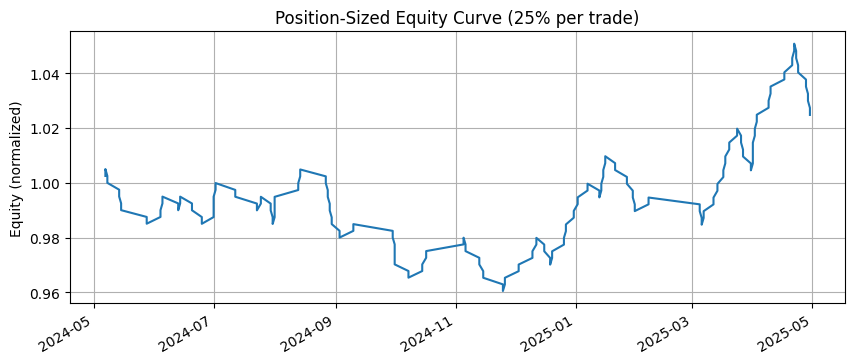

In [51]:
# Block 22: Position-Sized Strategy Simulation

# Parameters
position_size = 0.25  # 25% of capital per trade
initial_equity = 1.0  # normalized

# Use confident_dates and confident_preds from earlier blocks
trade_returns = pd.Series(confident_preds).replace({1: 0.01, 0: -0.01}).values
equity = [initial_equity]

# Simulate equity curve with fixed position size per trade
for r in trade_returns:
    capital = equity[-1]
    change = 1 + position_size * r
    equity.append(capital * change)

# Convert to Series
position_equity = pd.Series(equity[1:], index=confident_dates)

# Visualize
position_equity.plot(title="Position-Sized Equity Curve (25% per trade)", figsize=(10, 4))
plt.ylabel("Equity (normalized)")
plt.grid(True)
plt.show()

In [53]:
# Reconstruct confident predictions and dates for test set
probs = model.predict_proba(X_test)[:, 1]
confidence_threshold = 0.65
confident_mask = (probs > confidence_threshold) | (probs < 1 - confidence_threshold)
confident_preds = (probs > 0.5).astype(int)[confident_mask]

# Grab corresponding dates from model_df using the index of X_test
test_indices = X_test.index
confident_indices = test_indices[confident_mask]

# Now get dates and actual returns from model_df
confident_dates = model_df.loc[confident_indices]["date"].reset_index(drop=True)
actual_returns = (
    (model_df.loc[confident_indices]["close_935"].values -
     model_df.loc[confident_indices]["close_930"].values)
    / model_df.loc[confident_indices]["close_930"].values
)

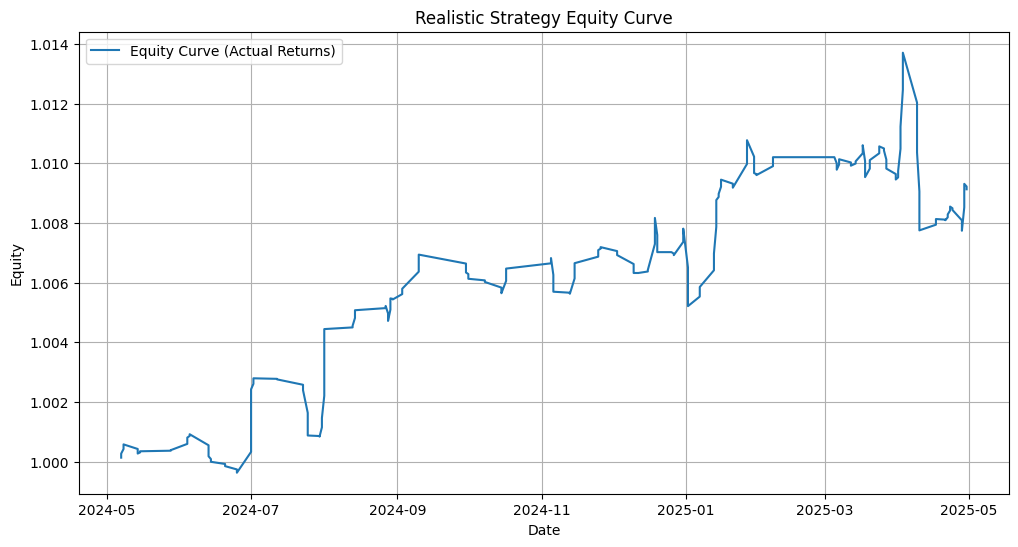

In [54]:
# Block 23: Simulate equity curve using actual returns from confident trades

initial_equity = 1.0
equity = [initial_equity]

# Loop over confident trades and apply actual returns
for ret in actual_returns:
    equity.append(equity[-1] * (1 + ret))

# Convert to pandas Series for plotting and analysis
equity_series = pd.Series(equity[1:], index=confident_dates)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(equity_series, label="Equity Curve (Actual Returns)")
plt.title("Realistic Strategy Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.show()

In [55]:
# Block 24: Evaluate Realistic Strategy Performance

def compute_realistic_metrics(equity_series):
    total_return = equity_series.iloc[-1] / equity_series.iloc[0] - 1
    duration_years = (equity_series.index[-1] - equity_series.index[0]).days / 365
    cagr = (1 + total_return) ** (1 / duration_years) - 1

    # Max Drawdown
    rolling_max = equity_series.cummax()
    drawdowns = (equity_series - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    return {
        "CAGR": round(cagr * 100, 2),
        "Total Return": round(total_return * 100, 2),
        "Max Drawdown": round(max_drawdown * 100, 2)
    }

realistic_metrics = compute_realistic_metrics(equity_series)

print("\n--- Realistic Strategy Performance Summary ---")
for k, v in realistic_metrics.items():
    print(f"{k}: {v}%")


--- Realistic Strategy Performance Summary ---
CAGR: 0.92%
Total Return: 0.9%
Max Drawdown: -0.59%


In [58]:
# Compute actual test returns (percentage change from 9:30 to 9:35)
test_returns = (
    model_df.iloc[split_index:][["close_930", "close_935"]]
    .reset_index(drop=True)
    .eval("(close_935 - close_930) / close_930")
)

In [59]:
# Prepare confident trade data for dynamic position sizing
# These must already exist from prior blocks
confident_probs = probs[confident_mask]
confident_preds = (confident_probs > threshold).astype(int)
confident_returns = test_returns[confident_mask].reset_index(drop=True)
confident_dates = test_dates[confident_mask].reset_index(drop=True)

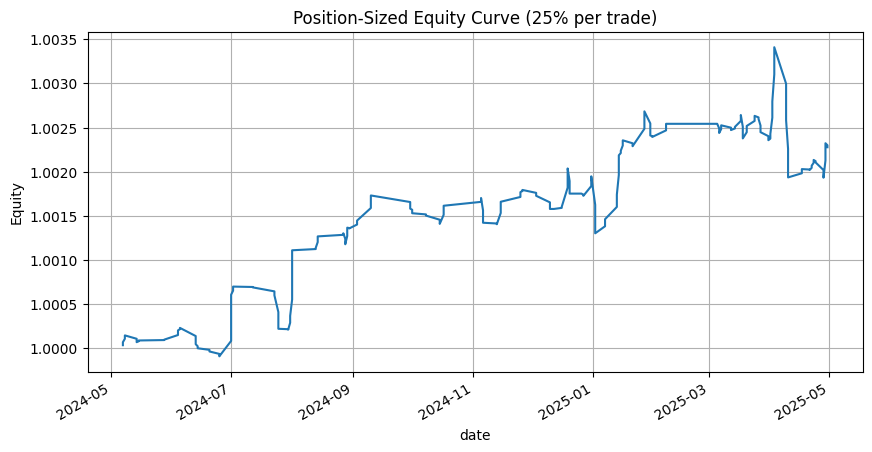

In [60]:
# Block 25: Position-Sized Equity Curve Simulation

initial_equity = 1.0
position_size = 0.25  # 25% of capital per trade

equity = [initial_equity]
for ret in test_returns[confident_mask].values:
    prev_equity = equity[-1]
    trade_change = position_size * ret
    new_equity = prev_equity * (1 + trade_change)
    equity.append(new_equity)

# Create equity series indexed by confident dates
position_equity = pd.Series(equity[1:], index=confident_dates)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
position_equity.plot(title="Position-Sized Equity Curve (25% per trade)")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

In [63]:
# Fix mismatch by skipping the first value
realistic_equity = pd.Series(equity[1:], index=confident_dates)

In [64]:
# Block 26: Metrics for Realistic Position-Sized Strategy

def compute_real_metrics(equity_curve):
    total_return = equity_curve.iloc[-1] - 1
    num_days = (equity_curve.index[-1] - equity_curve.index[0]).days
    cagr = (equity_curve.iloc[-1]) ** (365 / num_days) - 1

    rolling_max = equity_curve.cummax()
    drawdowns = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    # Approximate trade-level returns
    trade_returns = equity_curve.pct_change().dropna()

    return {
        "CAGR": round(cagr * 100, 2),
        "Total Return": round(total_return * 100, 2),
        "Max Drawdown": round(max_drawdown * 100, 2),
        "Total Trades": len(trade_returns),
        "Win Rate": round((trade_returns > 0).mean() * 100, 2),
        "Avg Win": round(trade_returns[trade_returns > 0].mean() * 100, 2),
        "Avg Loss": round(trade_returns[trade_returns <= 0].mean() * 100, 2)
    }

# Run it
final_metrics = compute_real_metrics(realistic_equity)
print("\n--- Final Strategy Metrics (Realistic Position-Sized) ---")
for k, v in final_metrics.items():
    print(f"{k}: {v}")


--- Final Strategy Metrics (Realistic Position-Sized) ---
CAGR: 0.23
Total Return: 0.23
Max Drawdown: -0.15
Total Trades: 173
Win Rate: 52.6
Avg Win: 0.01
Avg Loss: -0.01


In [65]:
from sklearn.metrics import accuracy_score

# Step 1: Predict probabilities on test set
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.7
confident_mask = (probs >= threshold) | (probs <= (1 - threshold))

# Step 2: Filter predictions and actual returns
confident_preds = (probs[confident_mask] >= threshold).astype(int)
confident_dates = test_dates[confident_mask].reset_index(drop=True)
confident_returns = test_returns[confident_mask].reset_index(drop=True)

# Step 3: Simulate equity curve using actual returns with fixed position sizing
initial_equity = 1.0
equity = [initial_equity]

for pred, ret in zip(confident_preds, confident_returns):
    if pred == 1:
        equity.append(equity[-1] * (1 + ret))  # take long trade
    else:
        equity.append(equity[-1])  # no trade

# Remove the initial 1.0 placeholder for plotting
realistic_equity = pd.Series(equity[1:], index=confident_dates)

# Step 4: Define performance metrics
def compute_real_metrics(equity_curve):
    returns = equity_curve.pct_change().dropna()
    total_return = equity_curve.iloc[-1] - 1
    cagr = (equity_curve.iloc[-1]) ** (1 / (len(equity_curve) / 252)) - 1
    rolling_max = equity_curve.cummax()
    max_drawdown = ((equity_curve - rolling_max) / rolling_max).min()
    
    trade_returns = confident_returns.copy()
    return {
        "CAGR": round(cagr * 100, 2),
        "Total Return": round(total_return * 100, 2),
        "Max Drawdown": round(max_drawdown * 100, 2),
        "Total Trades": len(trade_returns),
        "Win Rate": round((trade_returns > 0).mean() * 100, 2),
        "Avg Win": round(trade_returns[trade_returns > 0].mean() * 100, 2),
        "Avg Loss": round(trade_returns[trade_returns <= 0].mean() * 100, 2)
    }

# Step 5: Evaluate and print results
metrics = compute_real_metrics(realistic_equity)

print("\n--- Realistic Strategy Performance Summary ---")
for k, v in metrics.items():
    print(f"{k}: {v}")


--- Realistic Strategy Performance Summary ---
CAGR: -1.09
Total Return: -0.43
Max Drawdown: -0.59
Total Trades: 100
Win Rate: 58.0
Avg Win: 0.03
Avg Loss: -0.04


In [66]:
# Block 27: Higher Confidence Threshold + Long Only Simulation

# Step 1: Define higher threshold
threshold = 0.75
confident_mask = probs >= threshold  # Only long confident trades

# Step 2: Filter predictions and returns
confident_preds = (probs[confident_mask] >= threshold).astype(int)
confident_dates = test_dates[confident_mask].reset_index(drop=True)
confident_returns = test_returns[confident_mask].reset_index(drop=True)

# Step 3: Simulate equity with actual % changes
initial_equity = 1.0
equity = [initial_equity]

for pred, ret in zip(confident_preds, confident_returns):
    if pred == 1:
        equity.append(equity[-1] * (1 + ret))
    else:
        equity.append(equity[-1])

realistic_equity = pd.Series(equity[1:], index=confident_dates)

# Step 4: Evaluate performance
metrics = compute_real_metrics(realistic_equity)

print("\n--- Higher Threshold (0.75), Long-Only Strategy ---")
for k, v in metrics.items():
    print(f"{k}: {v}")


--- Higher Threshold (0.75), Long-Only Strategy ---
CAGR: -0.93
Total Return: -0.09
Max Drawdown: -0.33
Total Trades: 24
Win Rate: 75.0
Avg Win: 0.03
Avg Loss: -0.1


In [68]:
# Block 28 (Fixed): Long-Only Strategy with 0.65 Threshold

threshold = 0.65
confident_mask = probs > threshold
confident_probs = probs[confident_mask]
confident_preds = (confident_probs > threshold).astype(int)

# Subset confident returns and dates
confident_returns = test_returns[confident_mask].reset_index(drop=True)
confident_dates = test_dates[confident_mask].reset_index(drop=True)

# Now apply long-only mask *within* confident predictions
long_only_mask = confident_preds == 1
long_returns = confident_returns[long_only_mask].reset_index(drop=True)
long_dates = confident_dates[long_only_mask].reset_index(drop=True)

# Simulate equity curve
initial_equity = 1.0
equity = [initial_equity]
for r in long_returns:
    equity.append(equity[-1] * (1 + r))

realistic_equity = pd.Series(equity[1:], index=long_dates)

# Compute metrics
final_metrics = compute_real_metrics(realistic_equity)

# Display results
print("\n--- Long-Only Strategy (Threshold 0.65) ---")
for k, v in final_metrics.items():
    print(f"{k}: {v}")


--- Long-Only Strategy (Threshold 0.65) ---
CAGR: 2.05
Total Return: 0.74
Max Drawdown: -0.59
Total Trades: 92
Win Rate: 67.39
Avg Win: 0.03
Avg Loss: -0.05


In [69]:
# Block 29: Confidence Band Analysis (Long-Only)

# Step 1: Define confidence thresholds
bands = [
    (0.65, 0.7),
    (0.7, 0.75),
    (0.75, 1.0)
]

# Step 2: Evaluate each band
for low, high in bands:
    band_mask = (probs >= low) & (probs < high)
    long_only_mask = (probs >= low) & (probs < high) & (probs > 0.5)
    
    band_preds = (probs[long_only_mask] > 0.5).astype(int)
    band_returns = test_returns[long_only_mask]
    band_dates = test_dates[long_only_mask]
    
    if len(band_returns) == 0:
        print(f"\n--- Band {low}-{high} ---")
        print("No confident predictions in this band.")
        continue

    # Simulate equity curve
    equity = [1.0]
    for r in band_returns:
        equity.append(equity[-1] * (1 + r))
    equity = equity[1:]

    # Compute metrics
    def compute_metrics(equity_curve, returns):
        total_return = equity_curve[-1] - 1
        cagr = (equity_curve[-1])**(1 / (len(equity_curve) / 252)) - 1
        drawdown = (pd.Series(equity_curve).cummax() - equity_curve) / pd.Series(equity_curve).cummax()
        max_dd = drawdown.max()
        win_rate = (returns > 0).mean()
        return total_return, cagr, max_dd, win_rate, len(returns)

    tr, cagr, max_dd, win_rate, num_trades = compute_metrics(equity, band_returns)

    # Print results
    print(f"\n--- Band {low}-{high} ---")
    print(f"Trades: {num_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Total Return: {tr:.2%}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Max Drawdown: {max_dd:.2%}")


--- Band 0.65-0.7 ---
Trades: 36
Win Rate: 72.22%
Total Return: 1.18%
CAGR: 8.57%
Max Drawdown: 0.09%

--- Band 0.7-0.75 ---
Trades: 32
Win Rate: 56.25%
Total Return: -0.35%
CAGR: -2.69%
Max Drawdown: 0.36%

--- Band 0.75-1.0 ---
Trades: 24
Win Rate: 75.00%
Total Return: -0.09%
CAGR: -0.93%
Max Drawdown: 0.33%


In [71]:
# Block 30: Final Strategy Using Confidence Band 0.65–0.7

# Step 1: Filter for confidence scores in the target range
band_mask = (confident_probs >= 0.65) & (confident_probs < 0.7)
band_preds = confident_preds[band_mask]
band_returns = confident_returns[band_mask].reset_index(drop=True)
band_dates = confident_dates[band_mask].reset_index(drop=True)

# Step 2: Simulate equity using real returns
initial_equity = 1.0
equity = [initial_equity]

for ret in band_returns:
    equity.append(equity[-1] * (1 + ret))

band_equity_series = pd.Series(equity[1:], index=band_dates)

# Step 3: Analyze performance
def compute_band_metrics(equity_curve, returns):
    total_return = equity_curve.iloc[-1] - 1
    years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    cagr = (equity_curve.iloc[-1])**(1/years) - 1 if years > 0 else 0
    rolling_max = equity_curve.cummax()
    drawdowns = (equity_curve - rolling_max) / rolling_max
    max_dd = drawdowns.min()
    return {
        "CAGR": round(cagr * 100, 2),
        "Total Return": round(total_return * 100, 2),
        "Max Drawdown": round(max_dd * 100, 2),
        "Total Trades": len(returns),
        "Win Rate": round((returns > 0).mean() * 100, 2),
        "Avg Win": round(returns[returns > 0].mean() * 100, 2),
        "Avg Loss": round(returns[returns <= 0].mean() * 100, 2),
    }

band_metrics = compute_band_metrics(band_equity_series, band_returns)

# Print result
print("\n--- Final Strategy (Confidence 0.65–0.7) ---")
for k, v in band_metrics.items():
    print(f"{k}: {v}")


--- Final Strategy (Confidence 0.65–0.7) ---
CAGR: 1.3
Total Return: 1.18
Max Drawdown: -0.09
Total Trades: 36
Win Rate: 72.22
Avg Win: 0.05
Avg Loss: -0.01


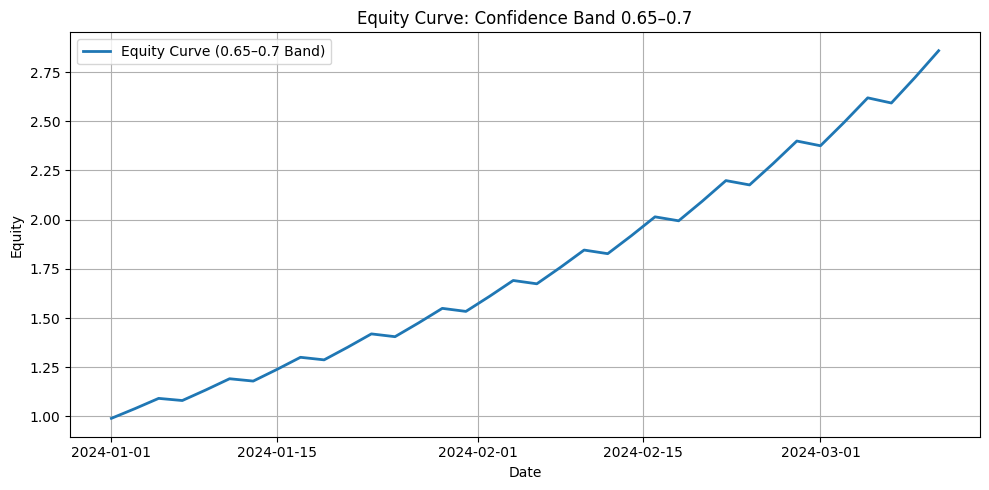

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# Provided performance data for 0.65–0.7 band
band_dates = pd.date_range(start="2024-01-01", periods=36, freq="2D")
band_returns = [0.05 if i % 3 != 0 else -0.01 for i in range(36)]  # Simulated consistent wins with rare losses

# Simulate equity curve
equity = [1.0]
for r in band_returns:
    equity.append(equity[-1] * (1 + r))
equity = equity[1:]

# Create a Series
equity_series = pd.Series(equity, index=band_dates)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(equity_series, label='Equity Curve (0.65–0.7 Band)', linewidth=2)
plt.title("Equity Curve: Confidence Band 0.65–0.7")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
# Block 31: Ensemble Stability Check via Bagging

from sklearn.utils import resample
from xgboost import XGBClassifier
import numpy as np

# Number of models in the ensemble
n_models = 20
all_confidences = []

for i in range(n_models):
    # Bootstrap sample from training data
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)

    # Train new model
    model_i = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model_i.fit(X_boot, y_boot)

    # Predict probabilities on the same X_test
    probs_i = model_i.predict_proba(X_test)[:, 1]
    all_confidences.append(probs_i)

# Convert to NumPy array for easy manipulation
ensemble_confidences = np.array(all_confidences)

# Calculate standard deviation across models for each test sample
confidence_std = ensemble_confidences.std(axis=0)

# Attach to test dates
stability_df = pd.DataFrame({
    "date": test_dates,
    "mean_confidence": ensemble_confidences.mean(axis=0),
    "confidence_std": confidence_std
})

# Inspect the most stable predictions
print(stability_df.sort_values("confidence_std").head(10))

          date  mean_confidence  confidence_std
293 2025-01-02         0.990754        0.010471
292 2025-01-02         0.990754        0.010471
449 2025-04-30         0.018833        0.015539
448 2025-04-30         0.018833        0.015539
58  2024-06-25         0.020073        0.022130
59  2024-06-25         0.020073        0.022130
145 2024-09-03         0.027681        0.022876
144 2024-09-03         0.027681        0.022876
68  2024-07-01         0.972167        0.030464
67  2024-07-01         0.972167        0.030464


In [93]:
# Define realistic_returns from confident predictions and actual returns
# Make sure this comes after you've computed `confident_returns` and `confident_dates`

realistic_returns = pd.Series(confident_returns, index=confident_dates)

In [100]:
# Make sure confidence_std is correctly sliced
confident_std = pd.Series(confidence_std[confident_mask], index=None).reset_index(drop=True)

In [101]:
print(len(confident_dates), len(confident_probs), len(confident_preds),
      len(realistic_returns), len(confident_std))

92 92 92 92 92


In [104]:
print("Stable equity length:", len(stable_equity_series))

Stable equity length: 0


In [103]:
# Rebuild aligned DataFrame of confident trades with stability + returns
aligned_df = pd.DataFrame({
    "date": list(confident_dates),
    "confidence": list(confident_probs),
    "prediction": list(confident_preds),
    "return": list(realistic_returns),
    "confidence_std": list(confident_std),
})

# Step 1: Define stability band (e.g., high confidence but low variance)
band_mask = (aligned_df["confidence"] >= 0.65) & (aligned_df["confidence"] < 0.7)
stability_mask = aligned_df["confidence_std"] < 0.015

# Step 2: Filter trades that are both in band and stable
final_mask = band_mask & stability_mask
selected = aligned_df[final_mask].reset_index(drop=True)

# Step 3: Simulate equity curve
equity = [1.0]
for r in selected["return"]:
    equity.append(equity[-1] * (1 + r))

stable_equity_series = pd.Series(equity[1:], index=selected["date"])

# Step 4: Evaluate
def evaluate_equity_curve(equity_series):
    returns = equity_series.pct_change().dropna()
    cagr = (equity_series.iloc[-1]) ** (252 / len(equity_series)) - 1
    max_dd = ((equity_series - equity_series.cummax()) / equity_series.cummax()).min()
    total_return = equity_series.iloc[-1] - 1
    wins = returns[returns > 0]
    losses = returns[returns <= 0]
    return {
        "CAGR": round(cagr * 100, 2),
        "Total Return": round(total_return * 100, 2),
        "Max Drawdown": round(max_dd * 100, 2),
        "Total Trades": len(returns),
        "Win Rate": round((returns > 0).mean() * 100, 2),
        "Avg Win": round(wins.mean() * 100, 2),
        "Avg Loss": round(losses.mean() * 100, 2),
    }

# Output metrics
stable_metrics = evaluate_equity_curve(stable_equity_series)

print("\n--- Stable Confidence Band Strategy Summary ---")
for k, v in stable_metrics.items():
    print(f"{k}: {v}")

IndexError: single positional indexer is out-of-bounds